## SHAP VALUES

In [70]:
import shap
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import defaultdict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
import pickle

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin

# Calcula el número de prestamos por wallet_address
class borrow_times(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.borrow_per_cli = None

    def fit(self, X, y=None):
        data = X.copy()
        object_var = data.select_dtypes(include='object').columns.to_list()
        vars = object_var + ['borrow_timestamp']

        self.borrow_per_cli = data[vars].groupby(*object_var).count()
        self.borrow_per_cli.rename(columns={'borrow_timestamp': 'borrow_times'}, inplace=True)
        self.borrow_per_cli.reset_index(inplace=True)
        return self

    def transform(self, X, y=None):
        data = X.copy()
        new_X = pd.merge(data, self.borrow_per_cli, on='wallet_address', how='left').fillna(0)
        new_X = new_X.sort_index(axis=1)
        return new_X

    def set_output(self,transform='default'):
        #No modificar este método
        return self
class tx_diff(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ts_diff_tx = None

    def fit(self, X, y=None):
        data = X.copy()
        self.data = data
        return self

    def transform(self, X, y=None):
        data = X.copy()
        data['ts_diff_tx'] = data['last_tx_timestamp'] - data['first_tx_timestamp']
        data.rename(columns={'risky_first_last_tx_timestamp_diff':'ts_diff_risky_tx'}, inplace=True)
        data.drop(columns=['last_tx_timestamp',
                           'first_tx_timestamp',
                           'risky_last_tx_timestamp',
                           'risky_first_tx_timestamp',
                        #    'borrow_timestamp'
                           ], inplace=True)

        new_data = data.sort_index(axis=1)
        return new_data

    def set_output(self,transform='default'):
        return self
class search_binary(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.binary_cols = []

    def fit(self, X, y=None):
        data = X.copy()
        for col in data.columns:
            diff_values = len(data[col].value_counts())
            is_binary = diff_values == 2
            if is_binary:
                self.binary_cols.append(col)
        return self

    def transform(self, X, y=None):
        data = X.copy()
        if self.binary_cols:
            binary_col = self.binary_cols[0] if isinstance(self.binary_cols, list) else self.binary_cols
            data[binary_col] = data[binary_col].astype('category')
        return data

    def set_output(self, transform='default'):
        return self
class time_tranf(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.time_cols = []

    def fit(self, X, y=None):
        data = X.copy()
        tcols = [col for col in data.columns if "timestamp" in col]
        self.time_cols = tcols
        return self

    def transform(self, X, y=None):
        data = X.copy()
        for col in self.time_cols:
            min_ms = data[col].min()
            data[col] = data[col] - min_ms
        return data

    def set_output(self,transform='default'):
        return self
class CategoryToInt(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.astype(np.int64)

    def set_output(self,transform='default'):
        return self

In [72]:
X_t0 = pd.read_parquet('X_t0.parquet')
X_t0 = X_t0[sorted(X_t0.columns)]

In [73]:
with open(".//xgb_best_pipe2.pkl", 'rb') as file:
    xgb_pipe = pickle.load(file)

xgb_step = xgb_pipe.named_steps['xgb_clf']
xgb_step.enable_categorical = True

In [74]:
pp = xgb_pipe.named_steps['preprocess']
X = pp.fit_transform(X_t0)
pd.set_option('display.max_columns', None)
X.head(5)

,avg_gas_paid_per_tx_eth,avg_risk_factor,avg_weighted_risk_factor,borrow_amount_avg_eth,borrow_amount_sum_eth,borrow_block_number,borrow_count,borrow_repay_diff_eth,borrow_times,borrow_timestamp,deposit_amount_sum_eth,deposit_count,incoming_tx_avg_eth,incoming_tx_count,incoming_tx_sum_eth,liquidation_amount_sum_eth,liquidation_count,market_adx,market_adxr,market_apo,market_aroonosc,market_aroonup,market_atr,market_cci,market_cmo,market_correl,market_dx,market_fastd,market_fastk,market_linearreg_slope,market_macd,market_macd_macdext,market_macd_macdfix,market_macdsignal,market_macdsignal_macdext,market_macdsignal_macdfix,market_max_drawdown_365d,market_natr,market_plus_di,market_plus_dm,market_ppo,market_rocp,market_rocr,max_eth_ever,max_risk_factor,min_eth_ever,net_incoming_tx_count,outgoing_tx_avg_eth,outgoing_tx_count,outgoing_tx_sum_eth,repay_amount_avg_eth,repay_amount_sum_eth,repay_count,risk_factor,risk_factor_above_threshold_daily_count,risky_sum_outgoing_amount_eth,risky_tx_count,risky_unique_contract_count,time_since_first_deposit,time_since_last_liquidated,total_available_borrows_avg_eth,total_available_borrows_eth,total_balance_eth,total_collateral_avg_eth,total_collateral_eth,total_gas_paid_eth,ts_diff_risky_tx,ts_diff_tx,unique_borrow_protocol_count,unique_lending_protocol_count,wallet_age,withdraw_amount_sum_eth,withdraw_deposit_diff_if_positive_eth,market_ht_trendmode
0,0.002363,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.010543,0.000000,3.730167e-05,0.000994,0.000181,0.002005,2.208903e-04,0.0,0.0,0.172094,0.392128,0.517933,0.838889,0.071429,0.171996,0.736508,0.571433,0.743903,0.374245,0.564673,0.806224,0.610022,0.559231,0.517933,0.558539,0.538005,0.512466,0.538302,0.0,0.163508,0.533767,0.271149,0.552217,0.601832,0.601832,0.000255,0.000000e+00,0.000001,0.408661,1.842120e-04,0.006161,2.363589e-04,0.0,0.0,0.0,9.853081e-07,0.0,0.0,0.0,0.0,0.000113,1.0,0.000000,0.000335,0.000771,0.000000,9.658996e-05,0.000785,0.0,0.129644,0.0,1.0,1.296240e-01,0.0,0.0,1
1,0.002367,0.000001,0.000000e+00,0.000004,1.967008e-07,0.000002,0.000217,3.552113e-07,0.010543,0.000004,3.730167e-05,0.000994,0.000180,0.002015,2.209266e-04,0.0,0.0,0.172094,0.392128,0.517933,0.838889,0.071429,0.171996,0.736508,0.571433,0.743903,0.374245,0.564673,0.806224,0.610022,0.559231,0.517933,0.558539,0.538005,0.512466,0.538302,0.0,0.163508,0.533767,0.271149,0.552217,0.601832,0.601832,0.000255,2.055947e-07,0.000001,0.408661,1.837697e-04,0.006176,2.363589e-04,0.0,0.0,0.0,4.880689e-03,0.0,0.0,0.0,0.0,0.000117,1.0,0.000395,0.000333,0.000771,0.000146,9.658996e-05,0.000788,0.0,0.129645,1.0,1.0,1.296249e-01,0.0,0.0,1
2,0.002372,0.002562,3.793286e-09,0.000007,6.801748e-07,0.000003,0.000435,1.228291e-06,0.010543,0.000005,3.730167e-05,0.000994,0.000180,0.002025,2.210156e-04,0.0,0.0,0.172094,0.392128,0.517933,0.838889,0.071429,0.171996,0.736508,0.571433,0.743903,0.374245,0.564673,0.806224,0.610022,0.559231,0.517933,0.558539,0.538005,0.512466,0.538302,0.0,0.163508,0.533767,0.271149,0.552217,0.601832,0.601832,0.000255,1.018406e-03,0.000001,0.408661,1.833296e-04,0.006190,2.363589e-04,0.0,0.0,0.0,1.685179e-02,0.0,0.0,0.0,0.0,0.000118,1.0,0.000394,0.000330,0.000771,0.000146,9.658996e-05,0.000792,0.0,0.129646,1.0,1.0,1.296252e-01,0.0,0.0,1
3,0.025979,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000211,0.000000,0.000000e+00,0.000000,0.000212,6.486939e-10,0.000166,0.000002,0.000071,1.835315e-07,0.0,0.0,0.172094,0.392128,0.517933,0.838889,0.071429,0.171996,0.736508,0.571433,0.743903,0.374245,0.564673,0.806224,0.610022,0.559231,0.517933,0.558539,0.538005,0.512466,0.538302,0.0,0.163508,0.533767,0.271149,0.552217,0.601832,0.601832,0.000000,0.000000e+00,0.000000,0.409813,2.504823e-07,0.000788,2.513873e-08,0.0,0.0,0.0,9.853081e-07,0.0,0.0,0.0,0.0,0.000215,1.0,0.000000,0.000066,0.000000,0.000000,1.666153e-09,0.001193,0.0,0.000042,0.0,1.0,8.946450e-05,0.0,0.0,1
4,0.002415,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000554,0.000000,0.000000e+00,0.002433

In [75]:
explainer = shap.TreeExplainer(xgb_step)
shap_values = explainer(X)

In [76]:
idx = 150

shap.initjs()
shap.force_plot(explainer.expected_value,
                shap_values.values[idx,:],
                X.iloc[idx,:],
                link="logit")

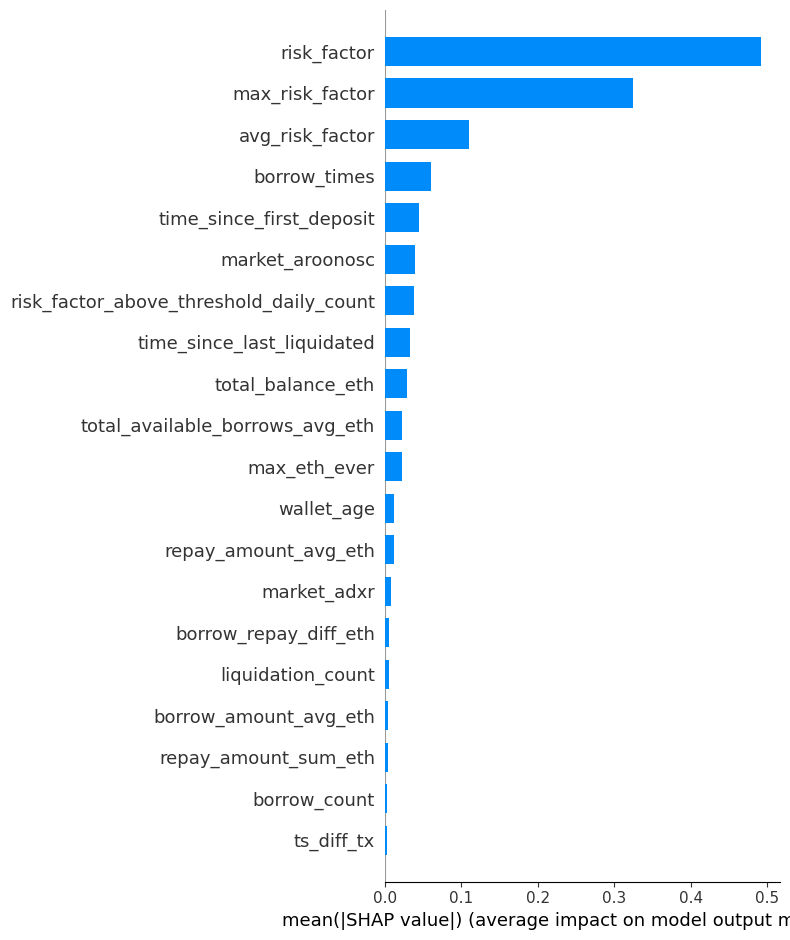

In [77]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [78]:
columns_idx = {column:i for i, column in enumerate(X.columns)}

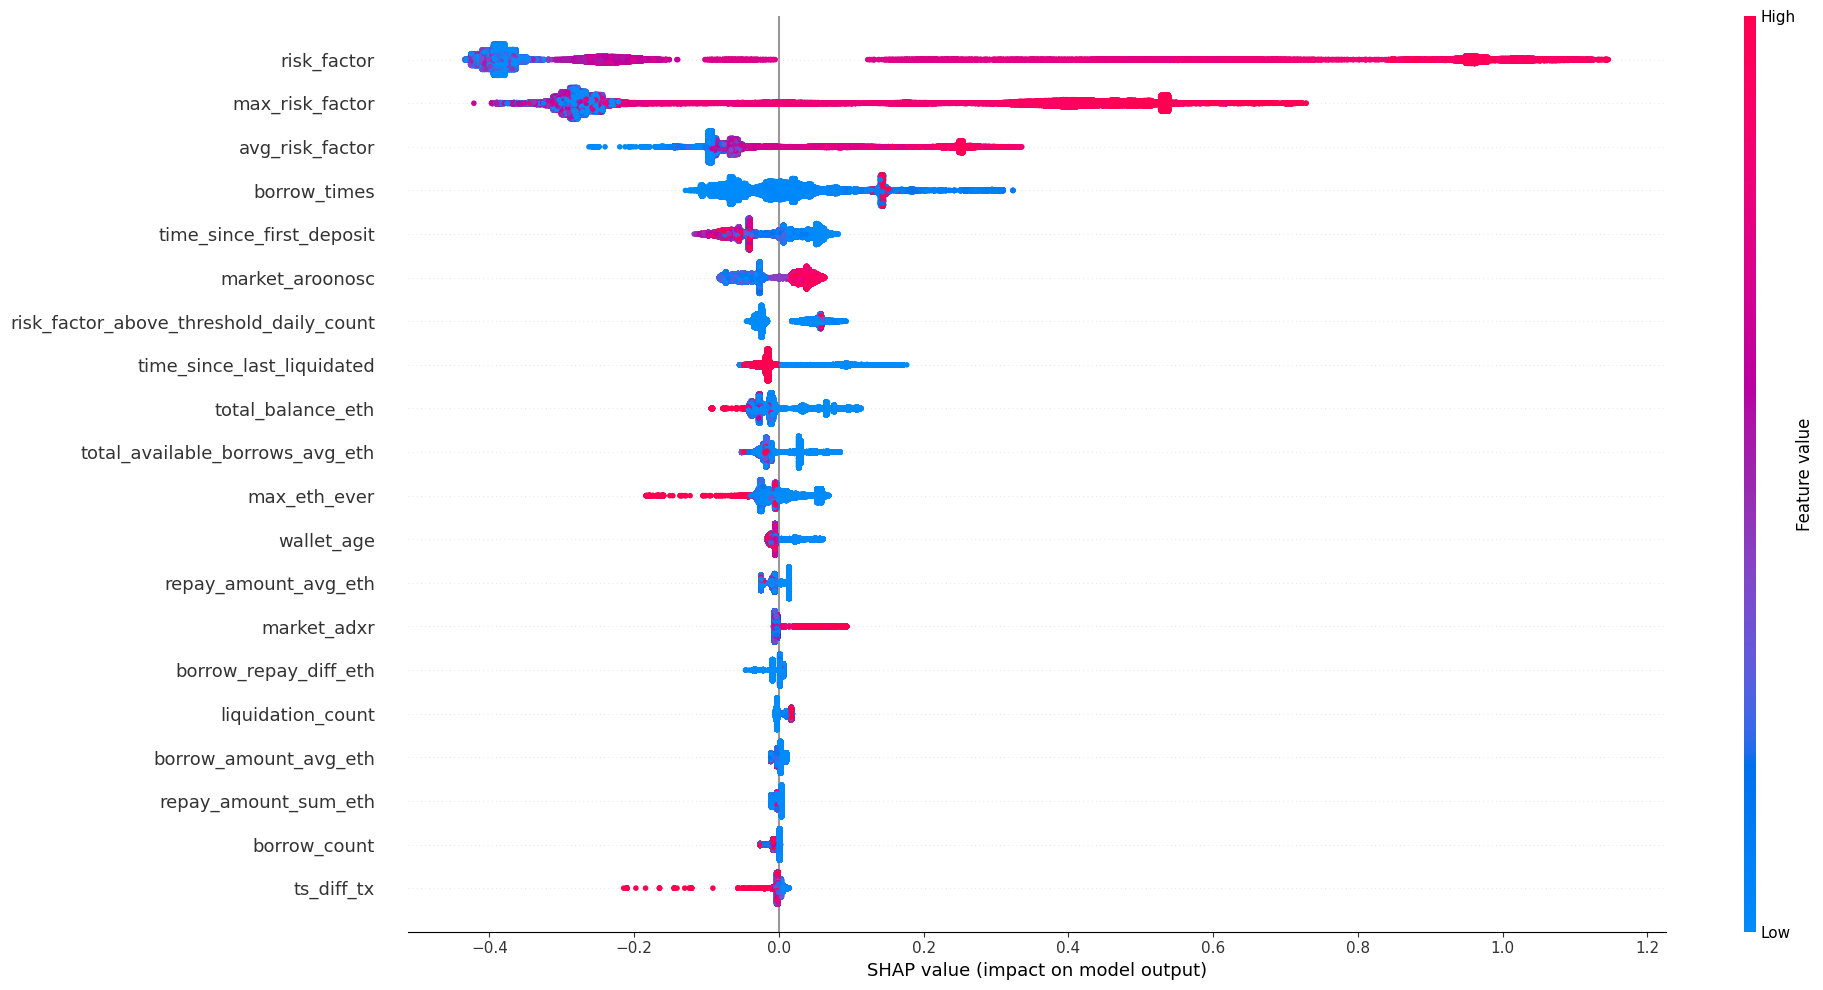

In [79]:
shap.summary_plot(shap_values, X, plot_size=[20,10])

#### Risk Factor

Notamos enseguida que todas las variables creadas a partir de risk_factor son bastante informativas en la morosidad de la transacción. A pesar de su parentesco, son suficientemente distintas en su comportamiento, por lo que no se decide por una o la otra. Es de esperar que esta métrica sea informativa simplemente por el nombre, lamentablemente es restrictivo para nuestro análisis no conocer su origen.

Luego, descartando estas tres primeras, nos disponemos a analizar las siguientes.

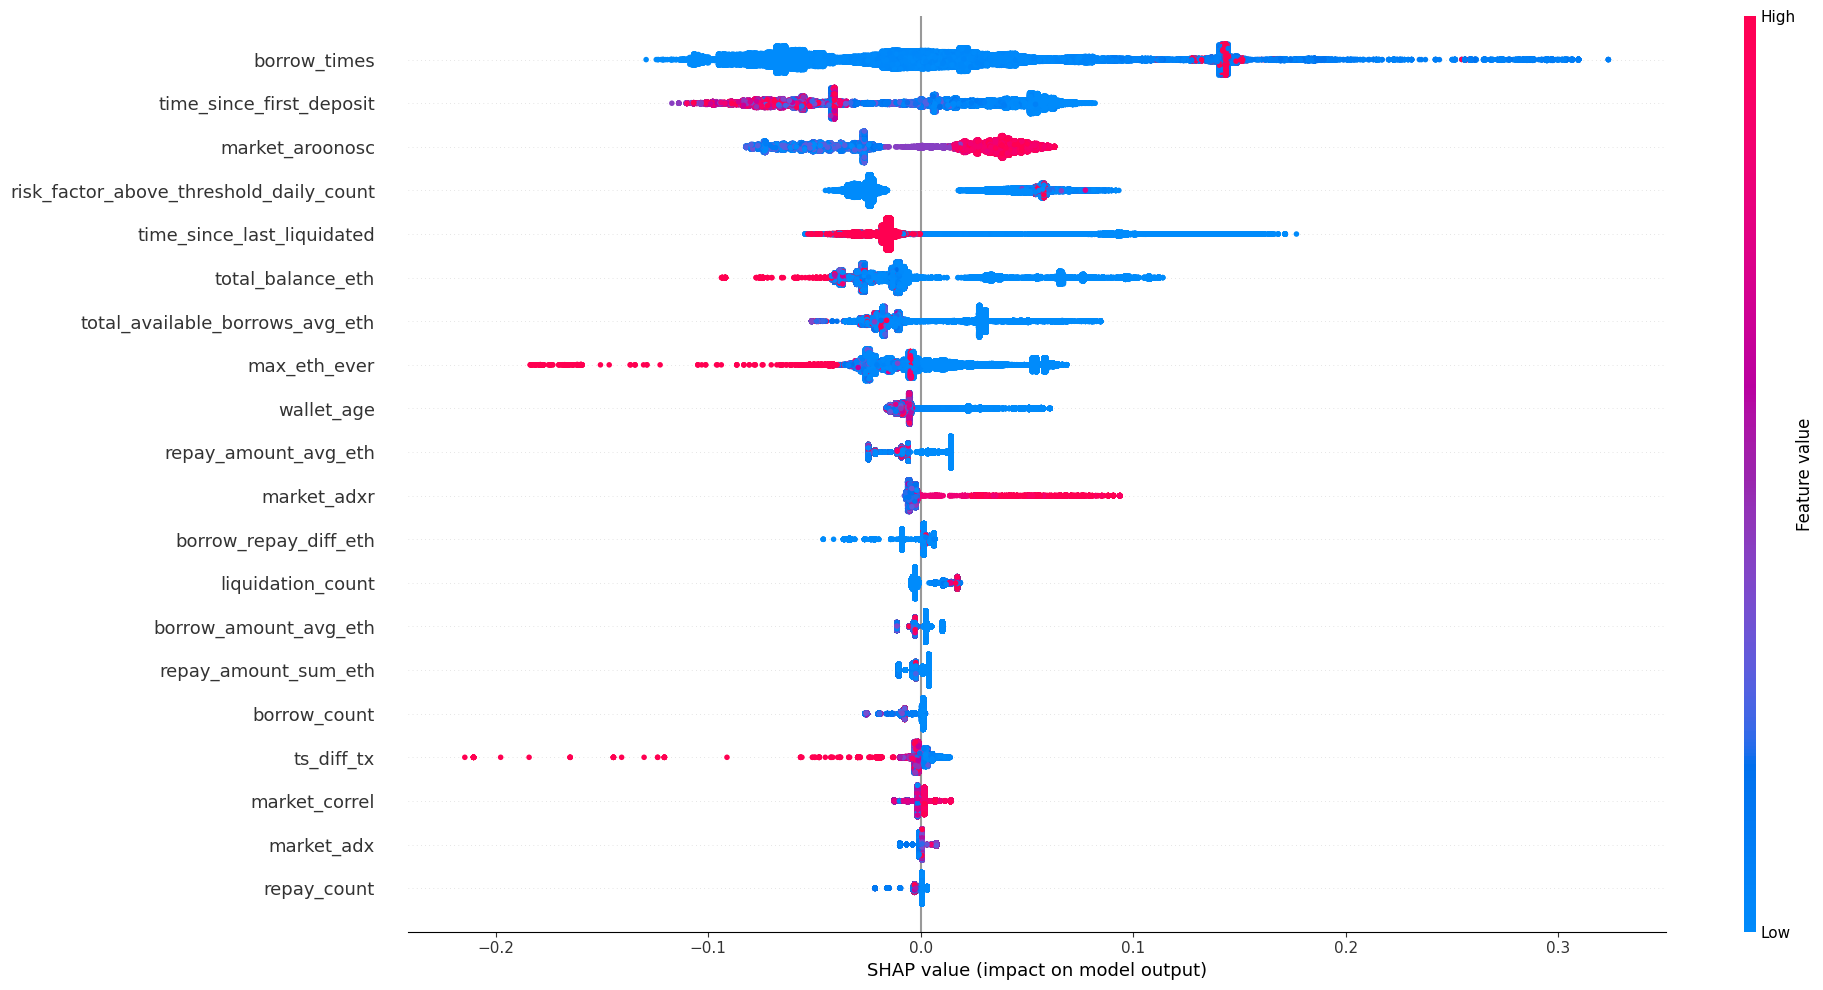

In [80]:
exclude = [columns_idx['risk_factor'], columns_idx['avg_risk_factor'], columns_idx['max_risk_factor']]
idxs = [i for i in range(len(X.columns)) if i not in exclude]
shap.summary_plot(shap_values[:, idxs], X.iloc[:, idxs], plot_size=[20,10])

#### Market Aroonosc

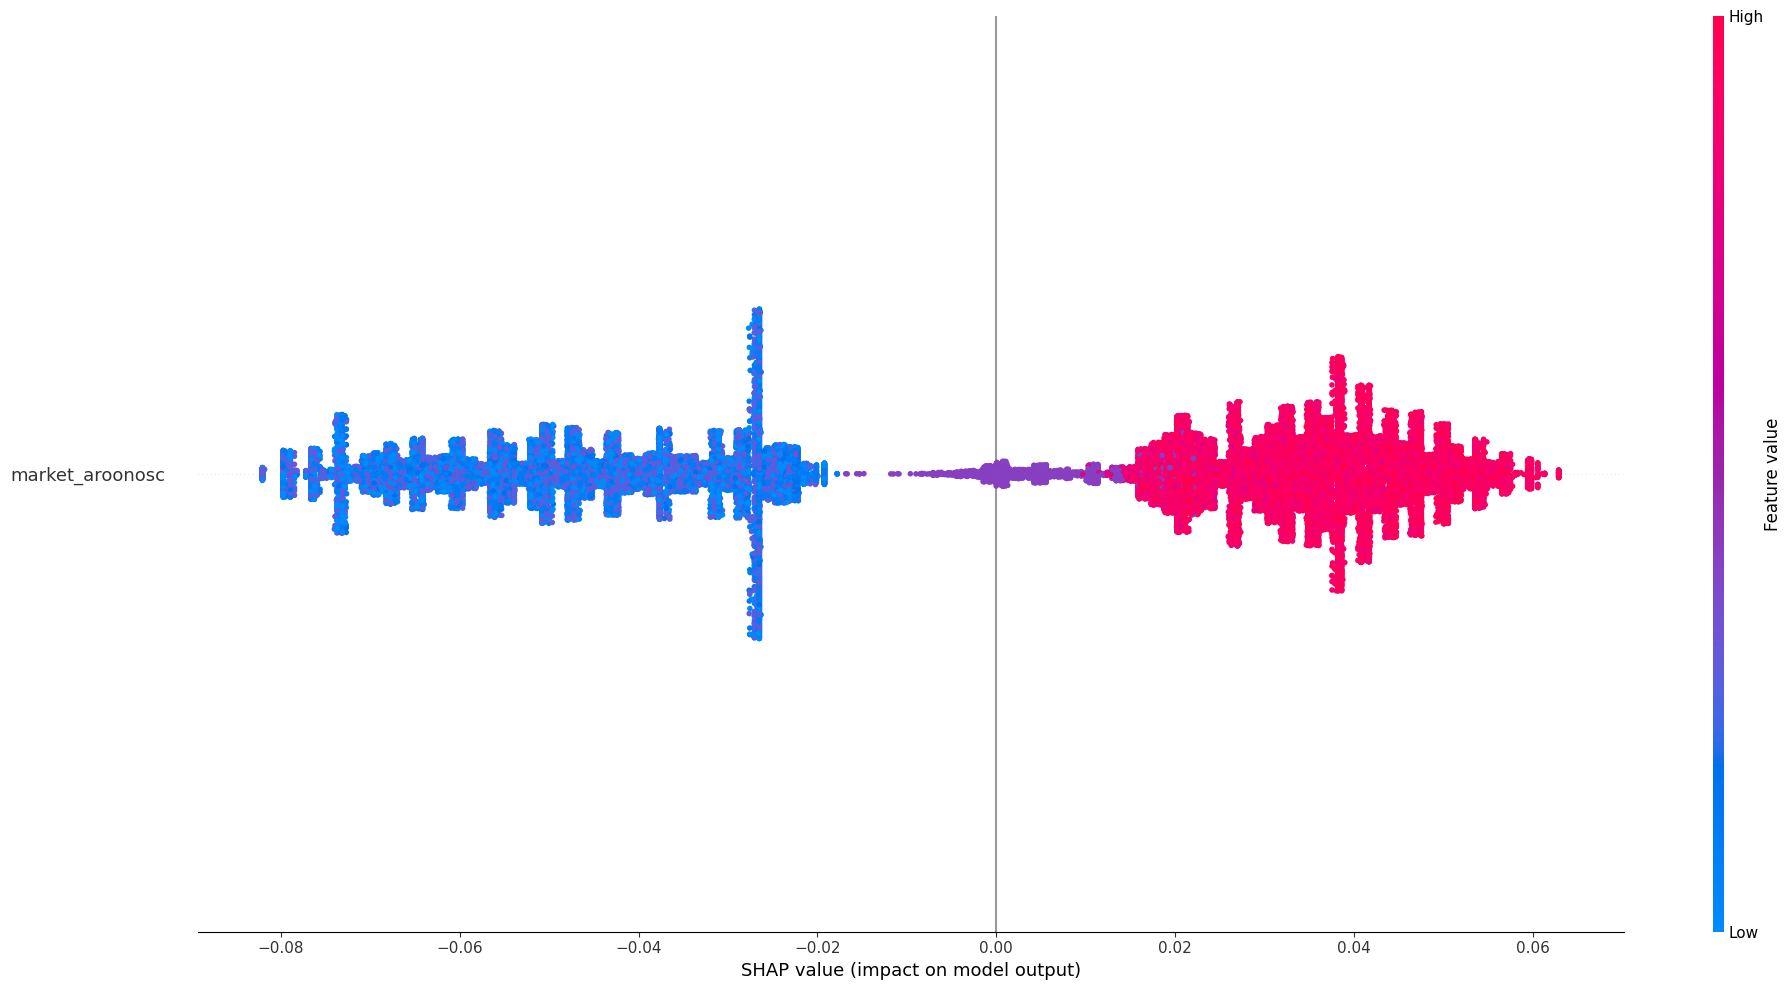

In [81]:
shap.summary_plot(shap_values[:, [columns_idx['market_aroonosc']]], X.iloc[:, [columns_idx['market_aroonosc']]], plot_size=[20,10])

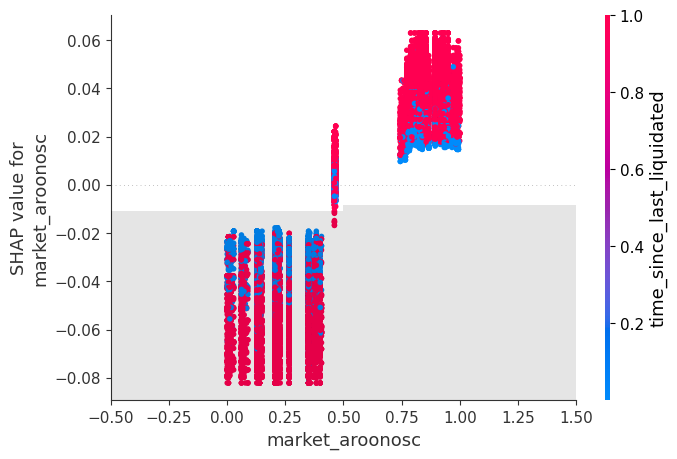

In [82]:
shap.plots.scatter(shap_values[:,'market_aroonosc'], color = shap_values)

#### Borrow Times

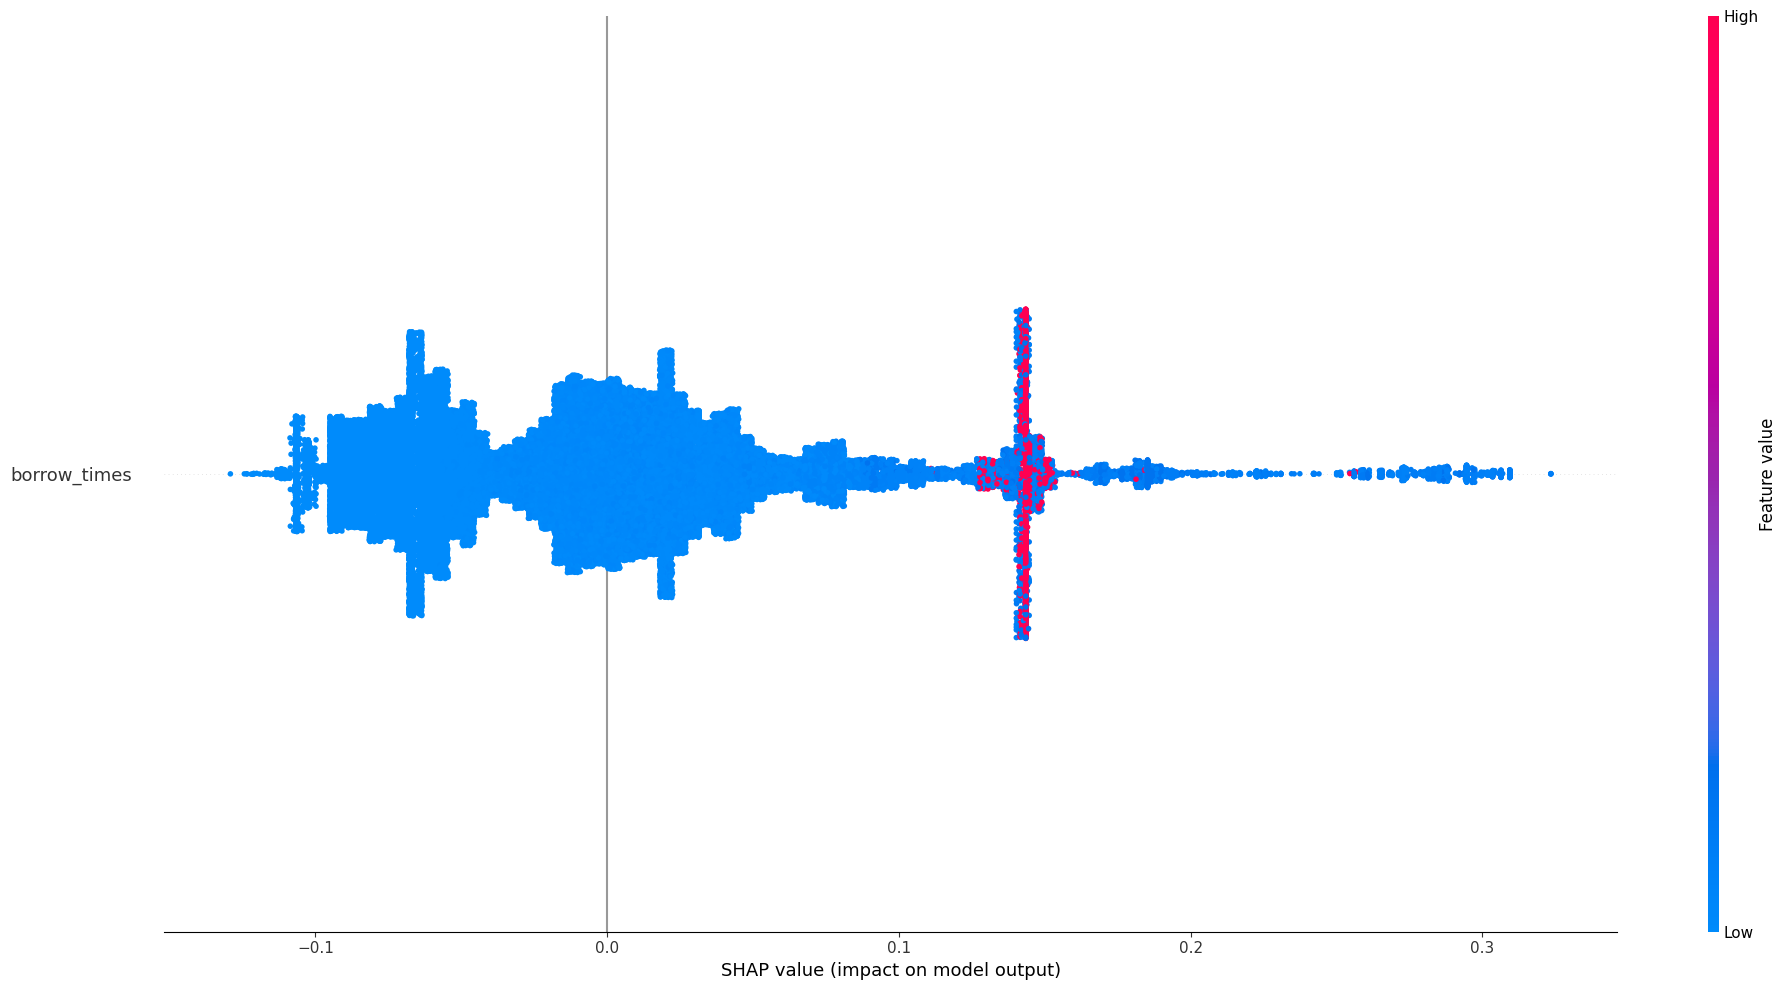

In [83]:
shap.summary_plot(shap_values[:, [columns_idx['borrow_times']]], X.iloc[:, [columns_idx['borrow_times']]], plot_size=[20,10])

In [84]:
# for name in feature_importance_names[:5]:
    # shap.plots.scatter(shap_values[:,name], color = shap_values)

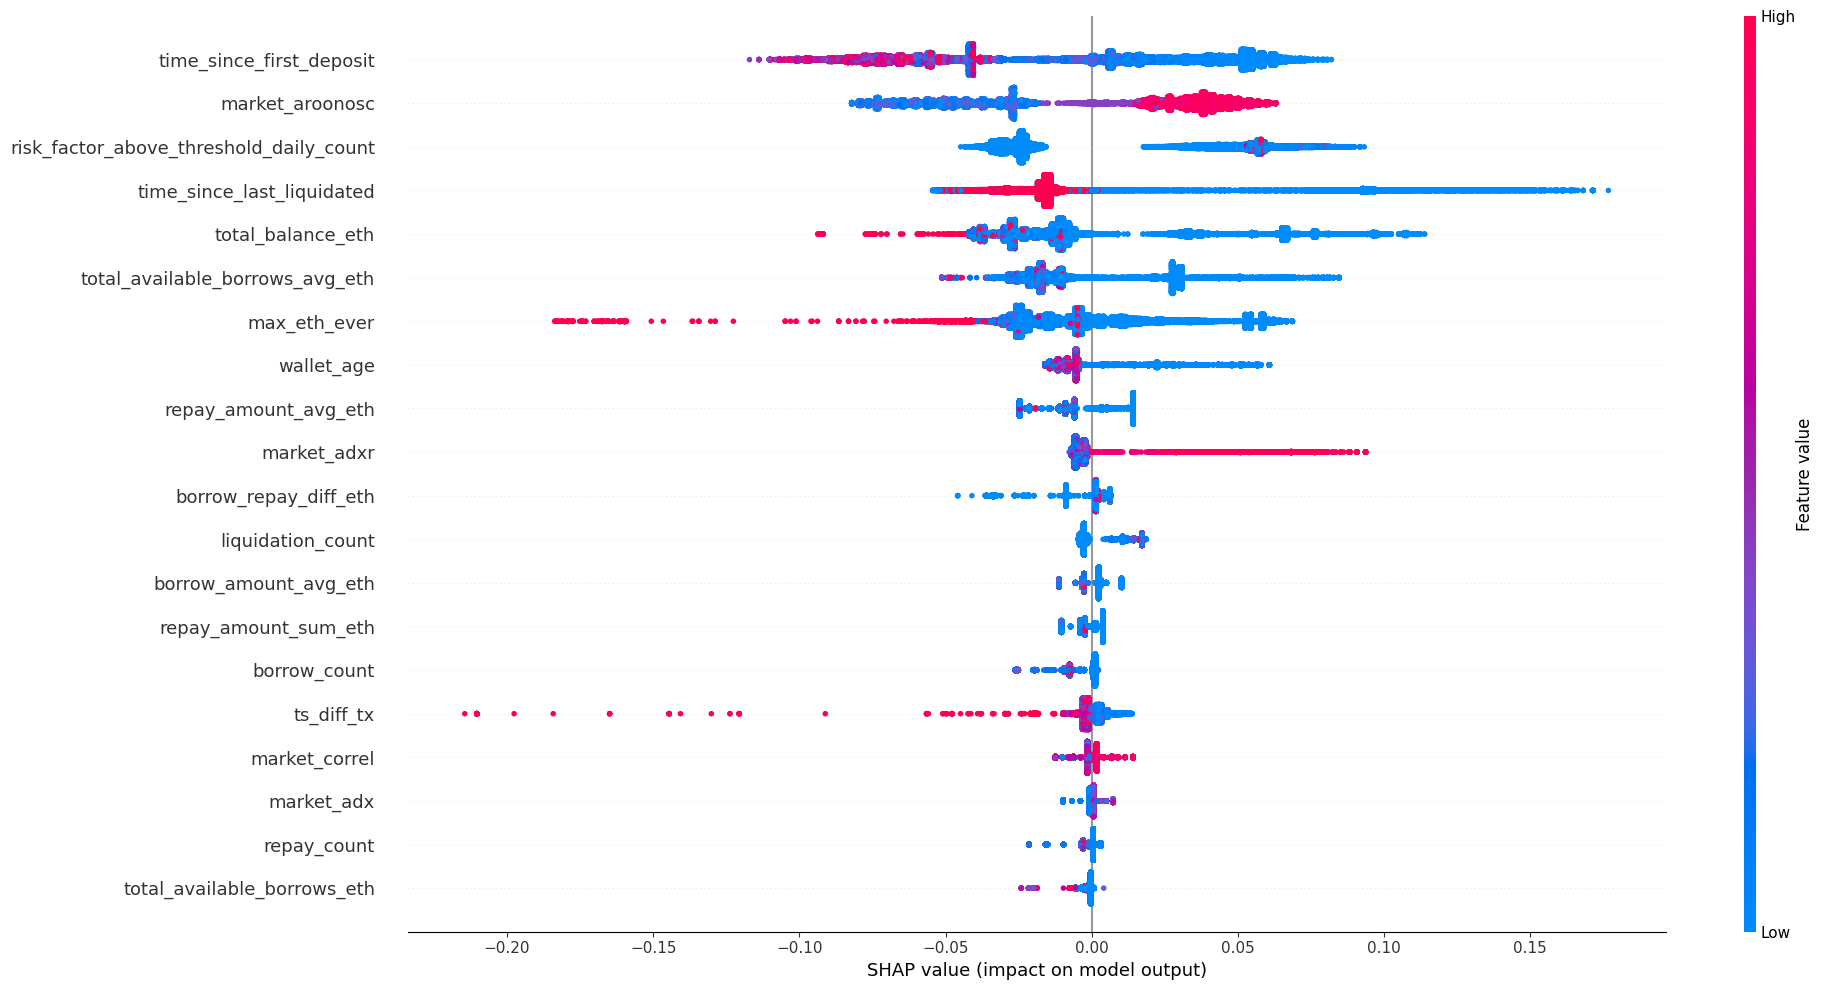

In [85]:
# idxs = list(range(len(X.columns)))
idxs.remove(columns_idx['borrow_times'])
shap.summary_plot(shap_values[:, idxs], X.iloc[:, idxs], plot_size=[20,10])

#### Wallet Age

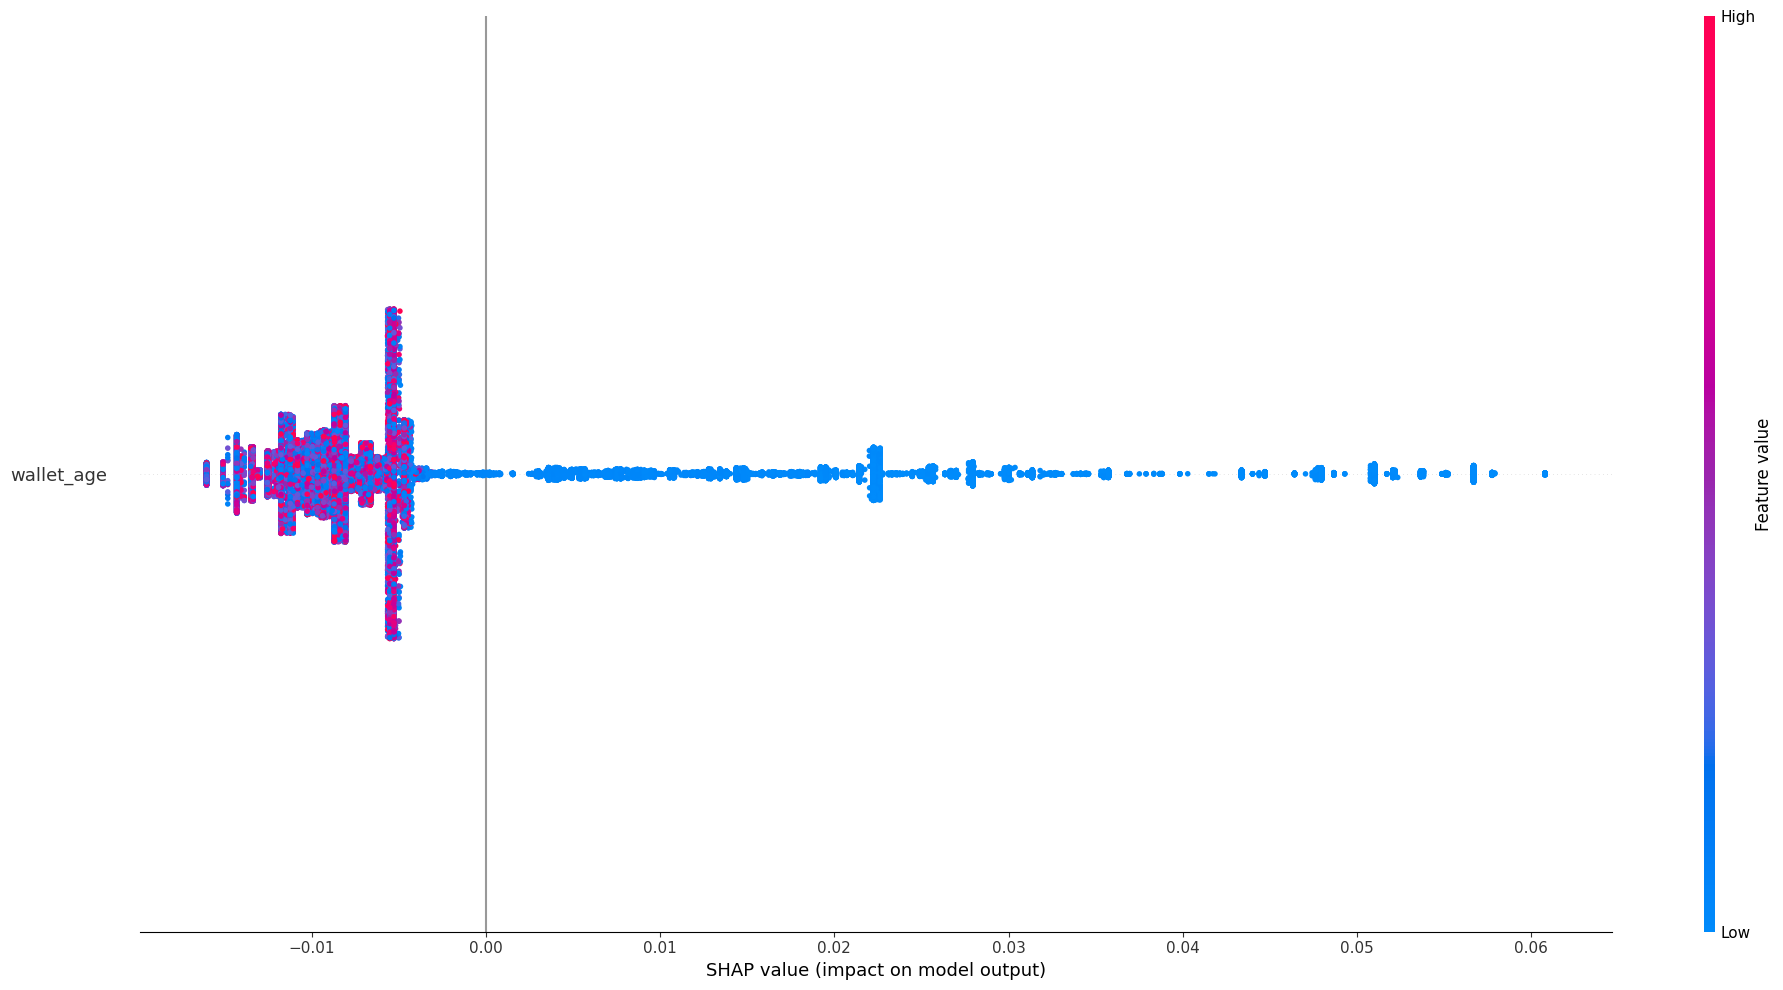

In [86]:
shap.summary_plot(shap_values[:, [columns_idx['wallet_age']]], X.iloc[:, [columns_idx['wallet_age']]], plot_size=[20,10])

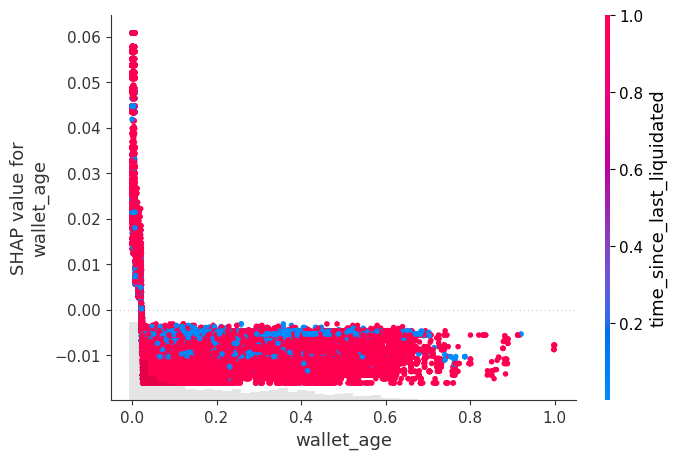

In [87]:
shap.plots.scatter(shap_values[:,'wallet_age'], color = shap_values)

Con wallet_age (Tiempo de existencia de la billetera en días), es decir, una variable que hace referencia al cliente (identificador wallet_address) y no la transacción, notamos que, en general, más aportan a la posibilidad de morosidad, las billeteras más nuevas. 

#### Variables Market

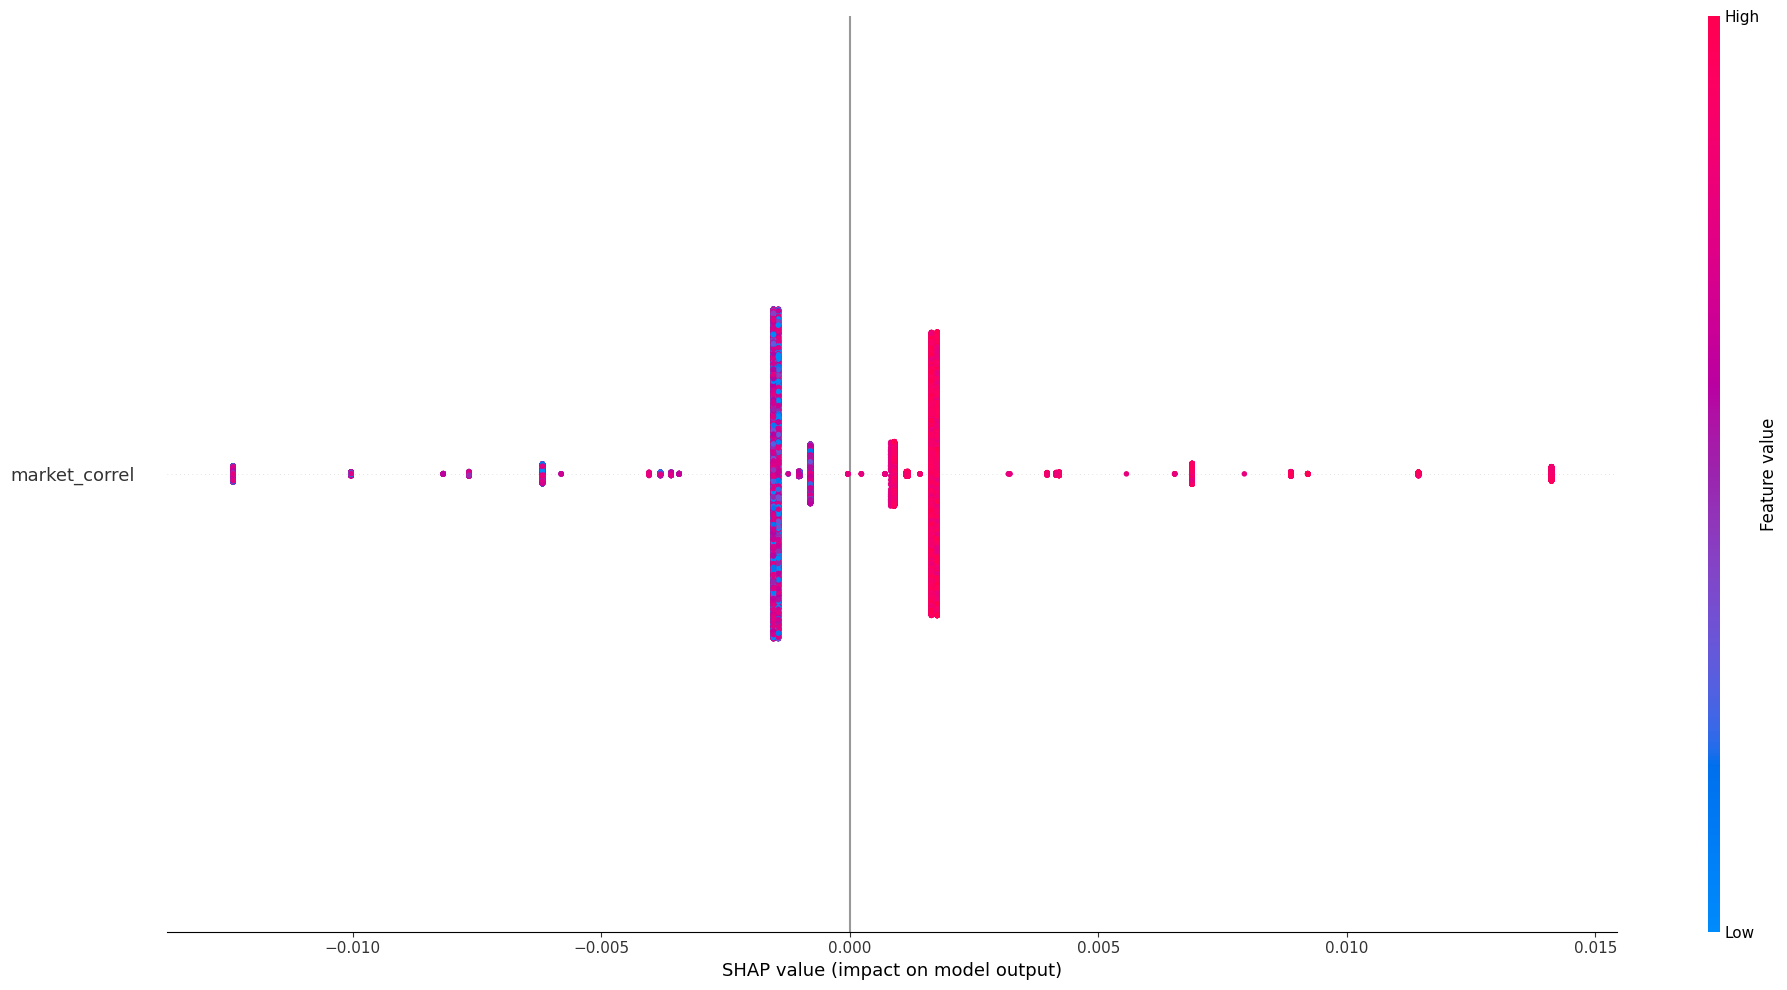

In [88]:
shap.summary_plot(shap_values[:, [columns_idx['market_correl']]], X.iloc[:, [columns_idx['market_correl']]], plot_size=[20,10])


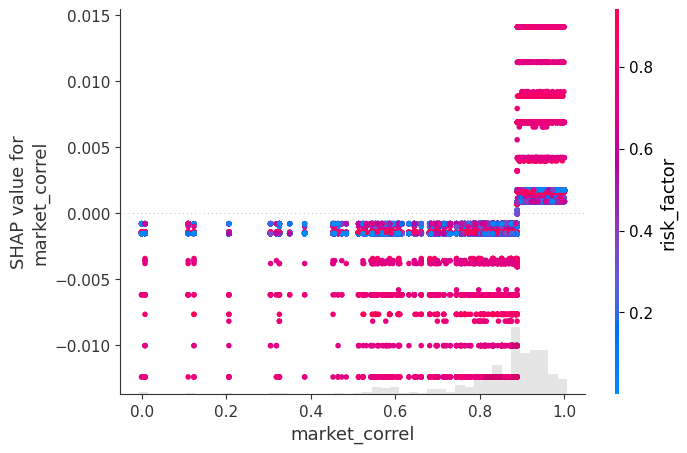

In [89]:
shap.plots.scatter(shap_values[:,'market_correl'], color = shap_values)

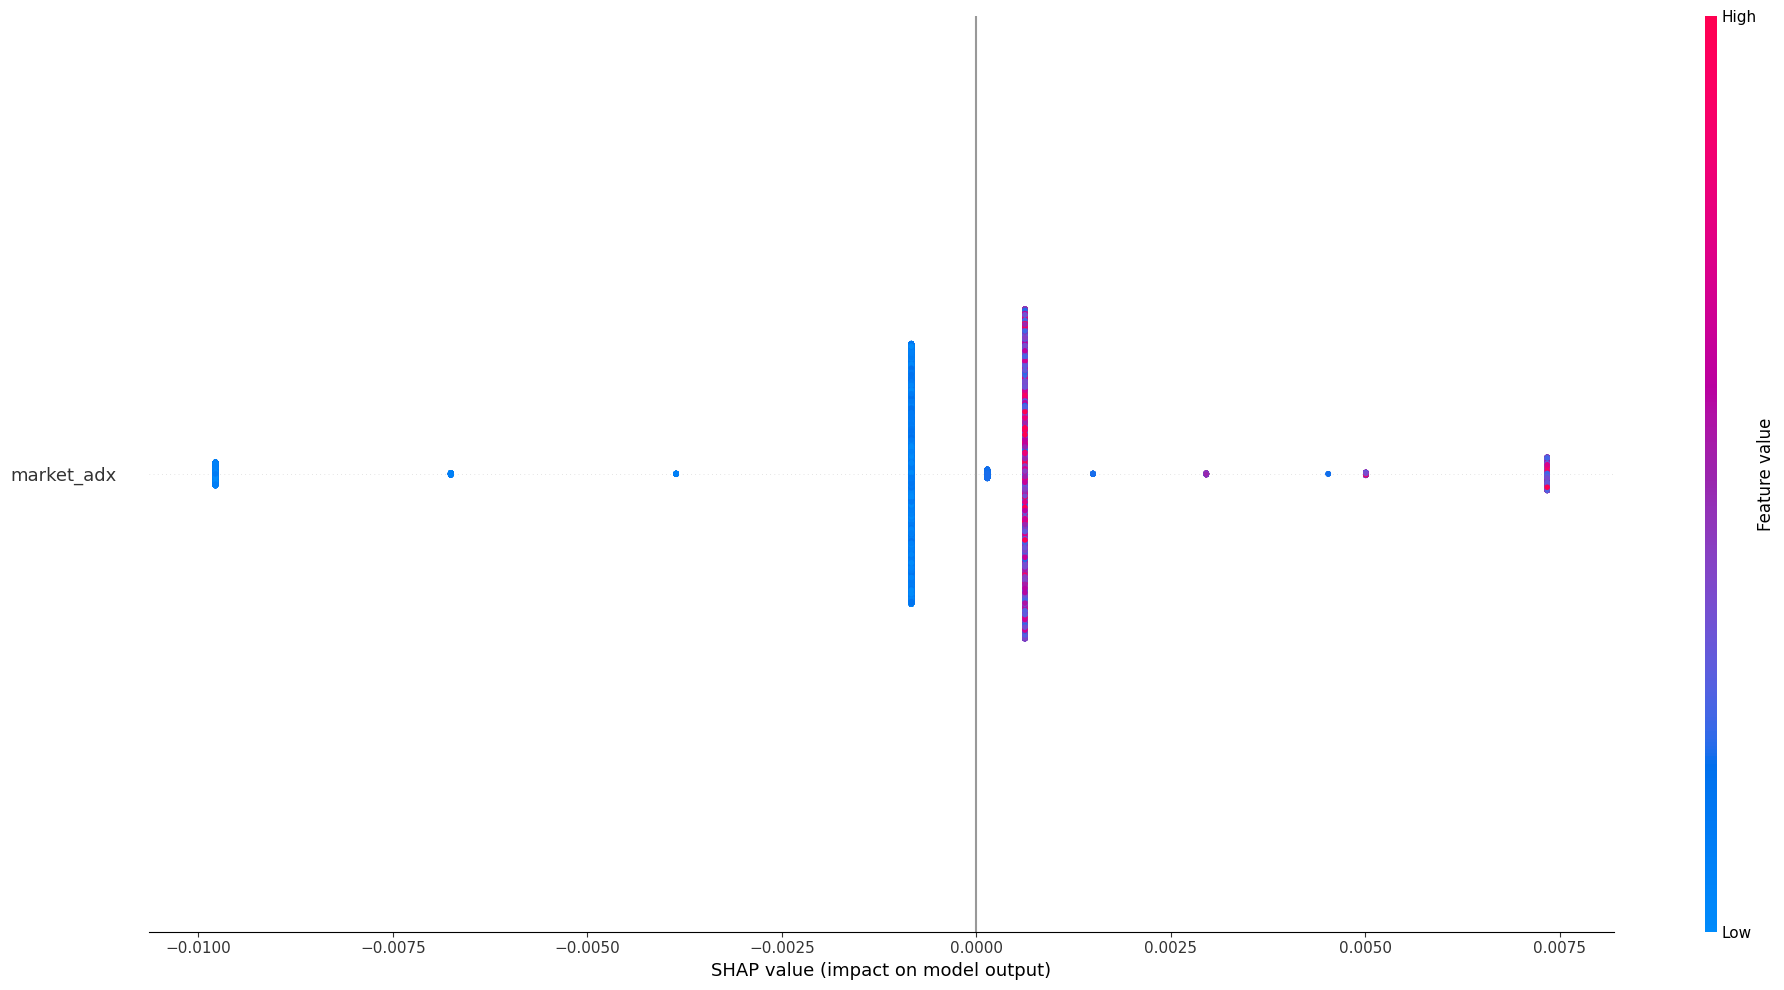

In [90]:
shap.summary_plot(shap_values[:, [columns_idx['market_adx']]], X.iloc[:, [columns_idx['market_adx']]], plot_size=[20,10])

d:\FCFM\Primavera2024\Lab\Labs_MDS\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\FCFM\Primavera2024\Lab\Labs_MDS\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


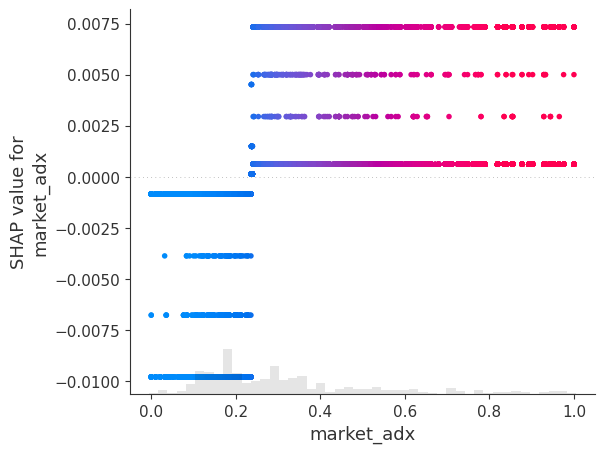

In [91]:
shap.plots.scatter(shap_values[:,'market_adx'], color = shap_values)

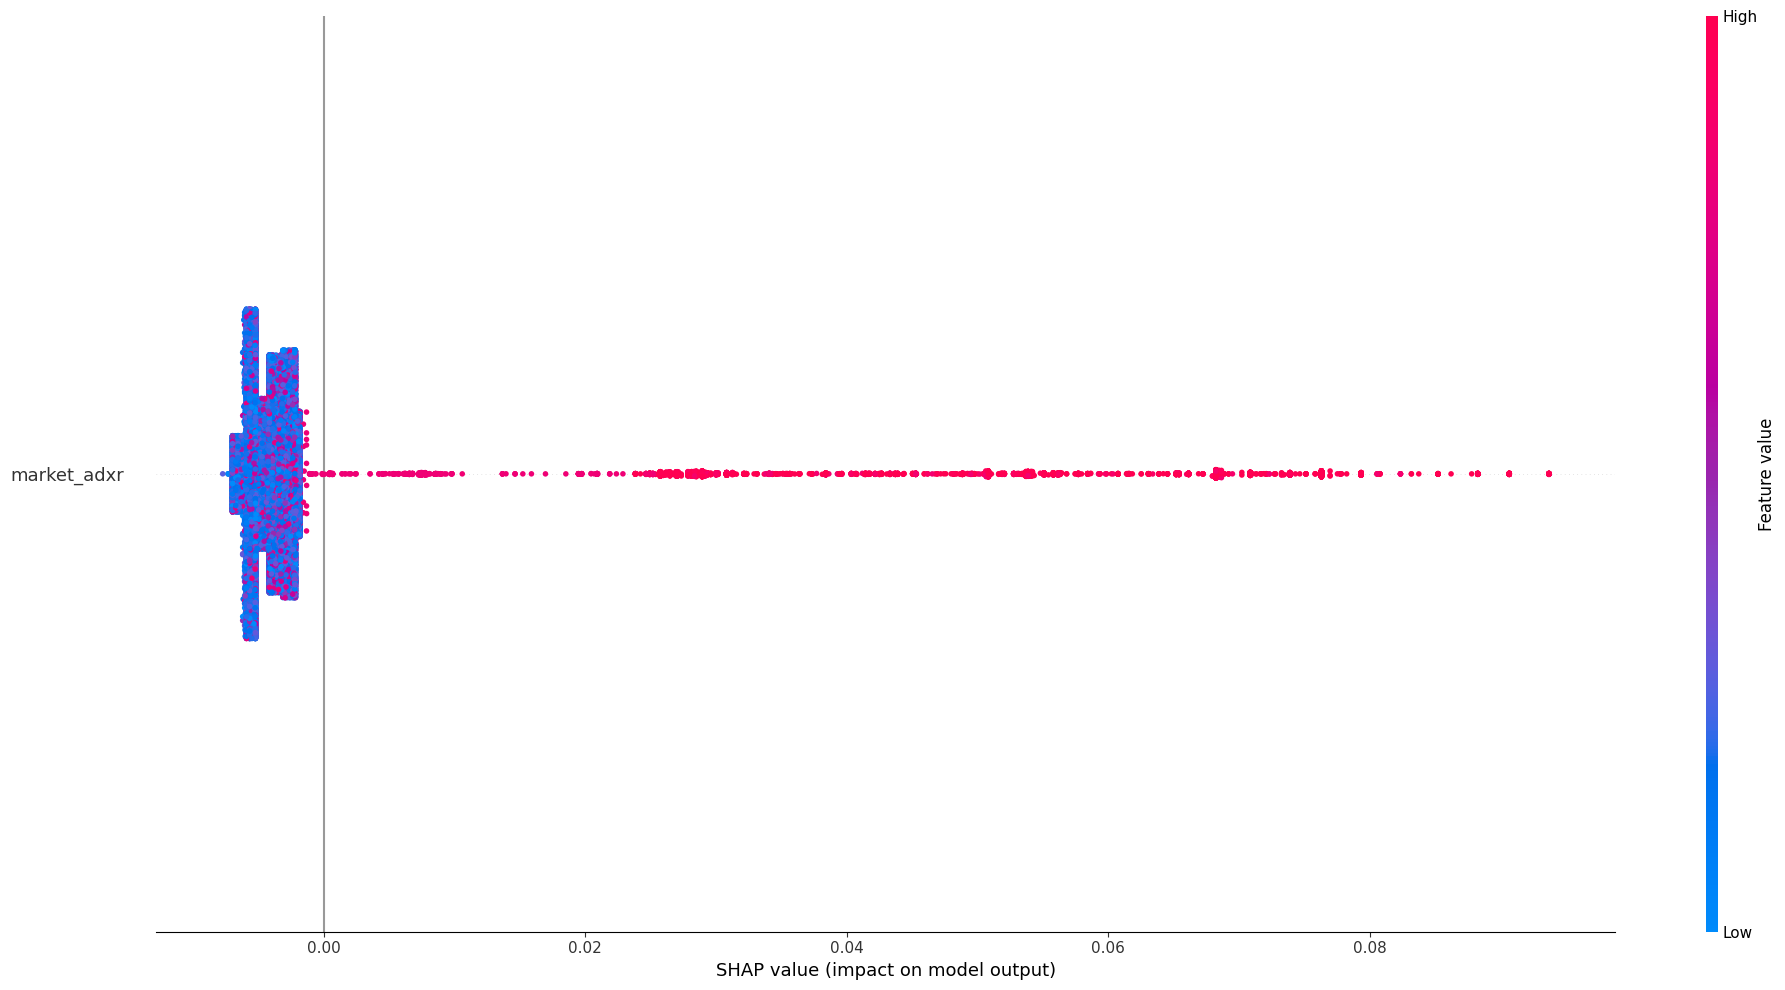

In [92]:
shap.summary_plot(shap_values[:, [columns_idx['market_adxr']]], X.iloc[:, [columns_idx['market_adxr']]], plot_size=[20,10])

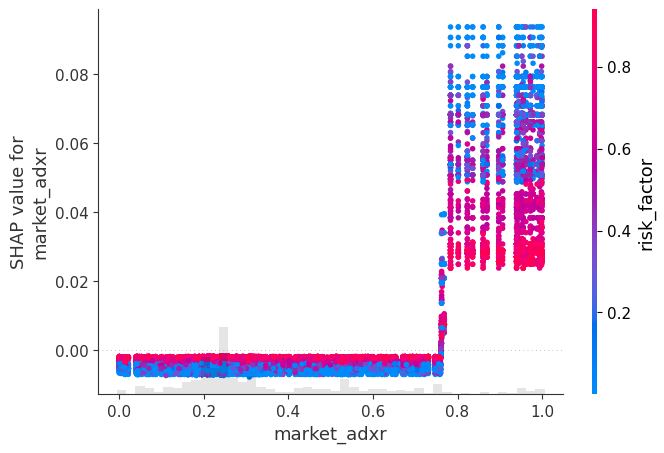

In [93]:
shap.plots.scatter(shap_values[:,'market_adxr'], color = shap_values)

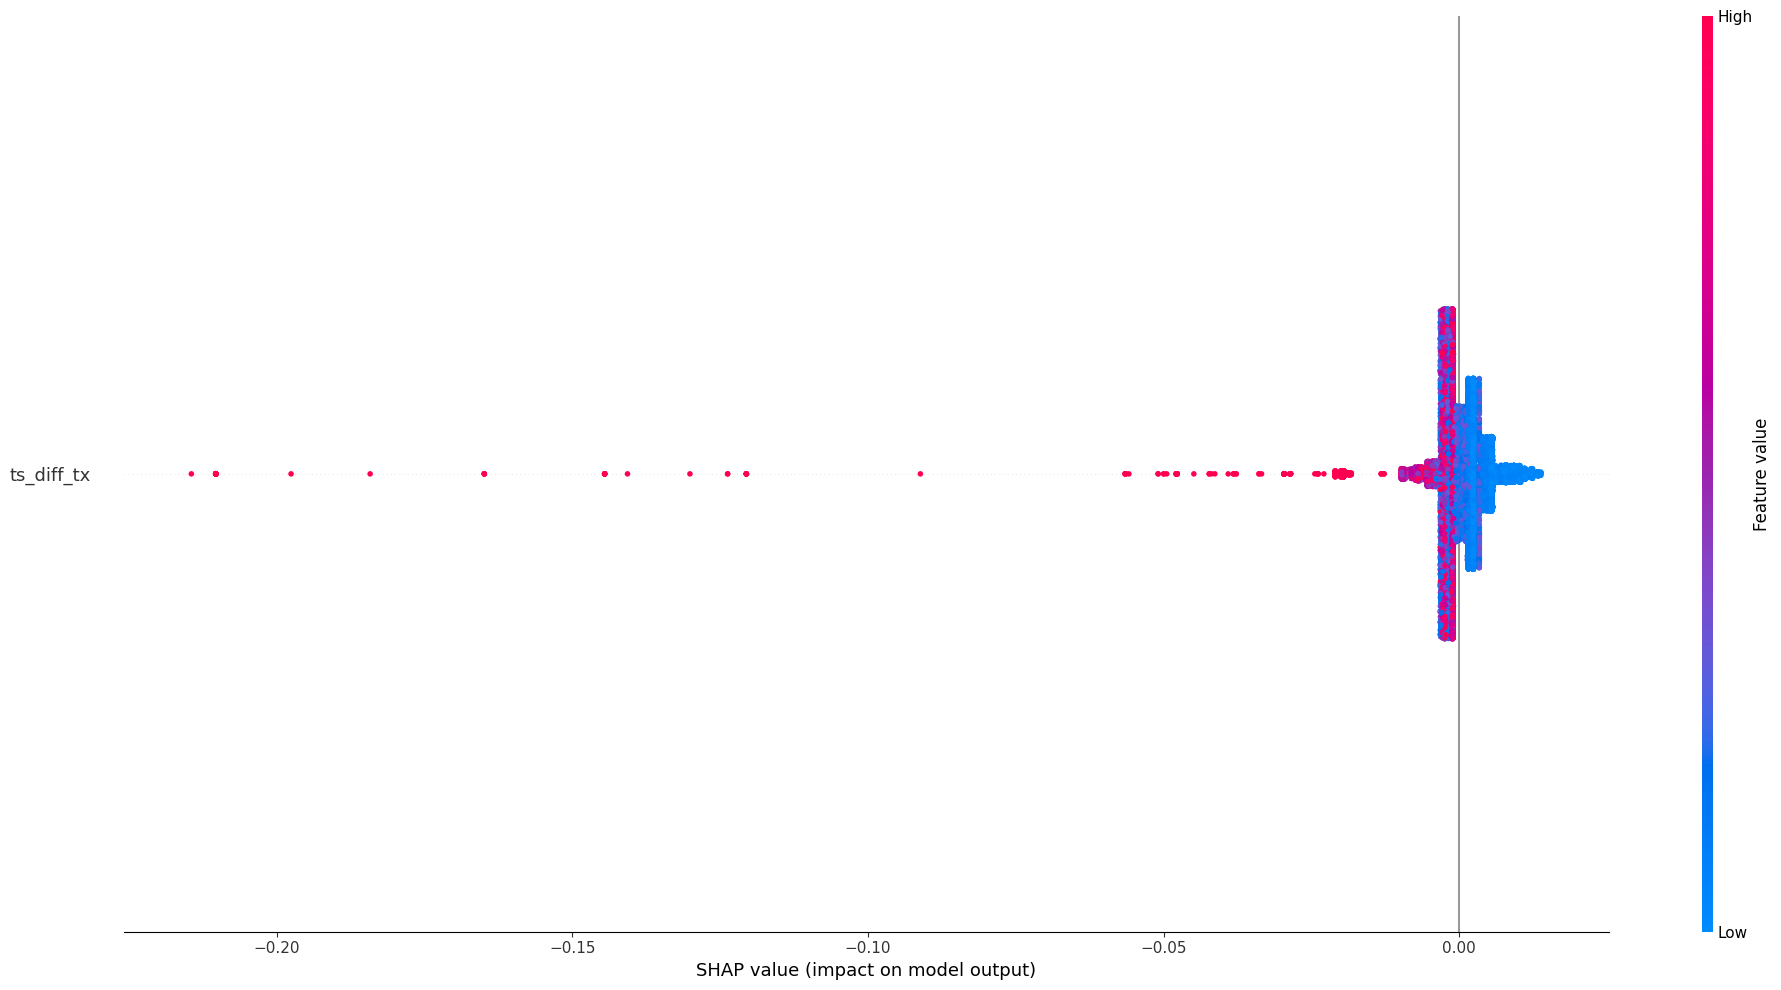

In [94]:
shap.summary_plot(shap_values[:, [columns_idx['ts_diff_tx']]], X.iloc[:, [columns_idx['ts_diff_tx']]], plot_size=[20,10])


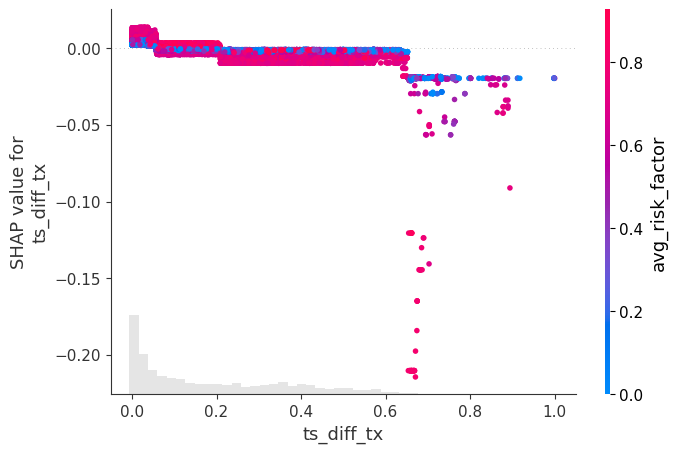

In [95]:
shap.plots.scatter(shap_values[:,'ts_diff_tx'], color=shap_values)


#### Time Since Last Liquidated

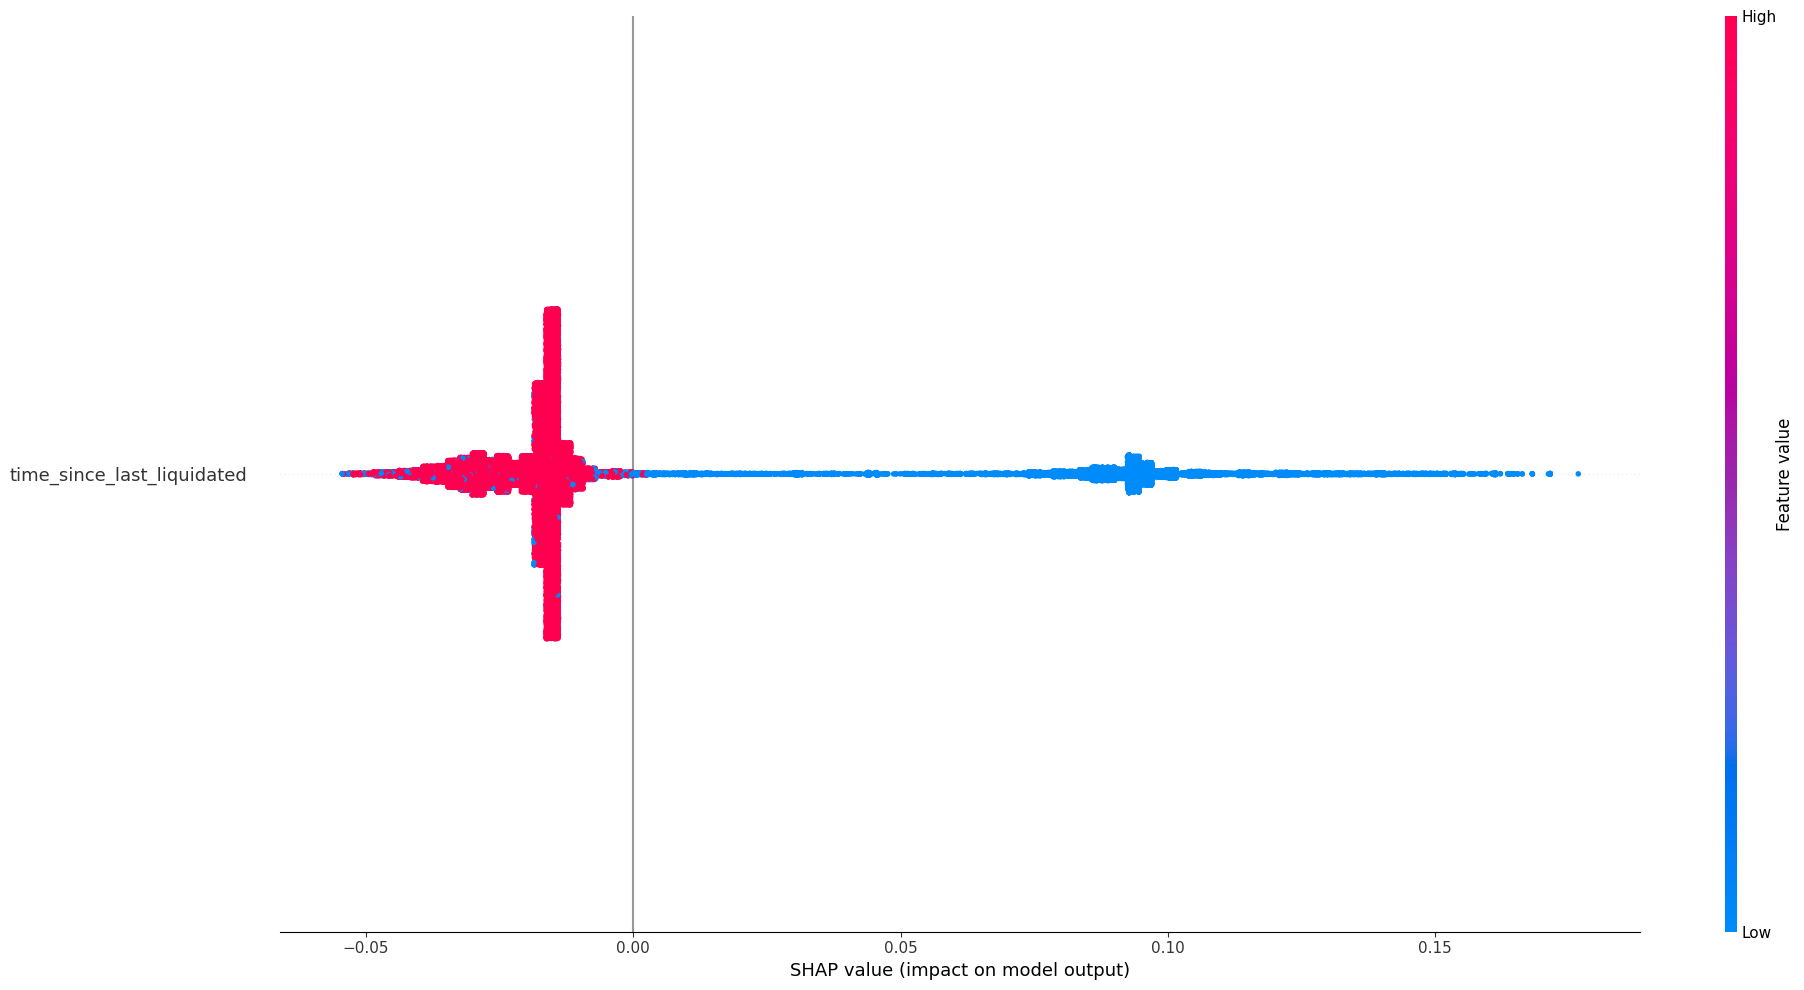

In [96]:
shap.summary_plot(shap_values[:, [columns_idx['time_since_last_liquidated']]], X.iloc[:, [columns_idx['time_since_last_liquidated']]], plot_size=[20,10])

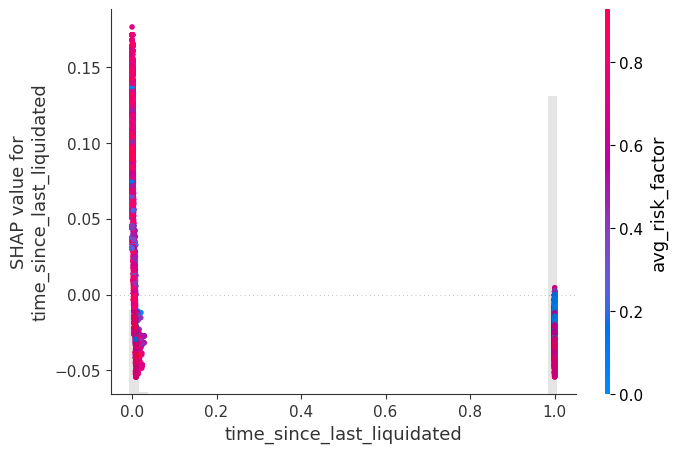

In [97]:
shap.plots.scatter(shap_values[:,'time_since_last_liquidated'], color=shap_values)

In [98]:
explainer = shap.TreeExplainer(xgb_step)
X_minus_outliers = X[X['time_since_last_liquidated'] == X['time_since_last_liquidated'].value_counts().index[0]]
less_shap_values = explainer(X_minus_outliers)

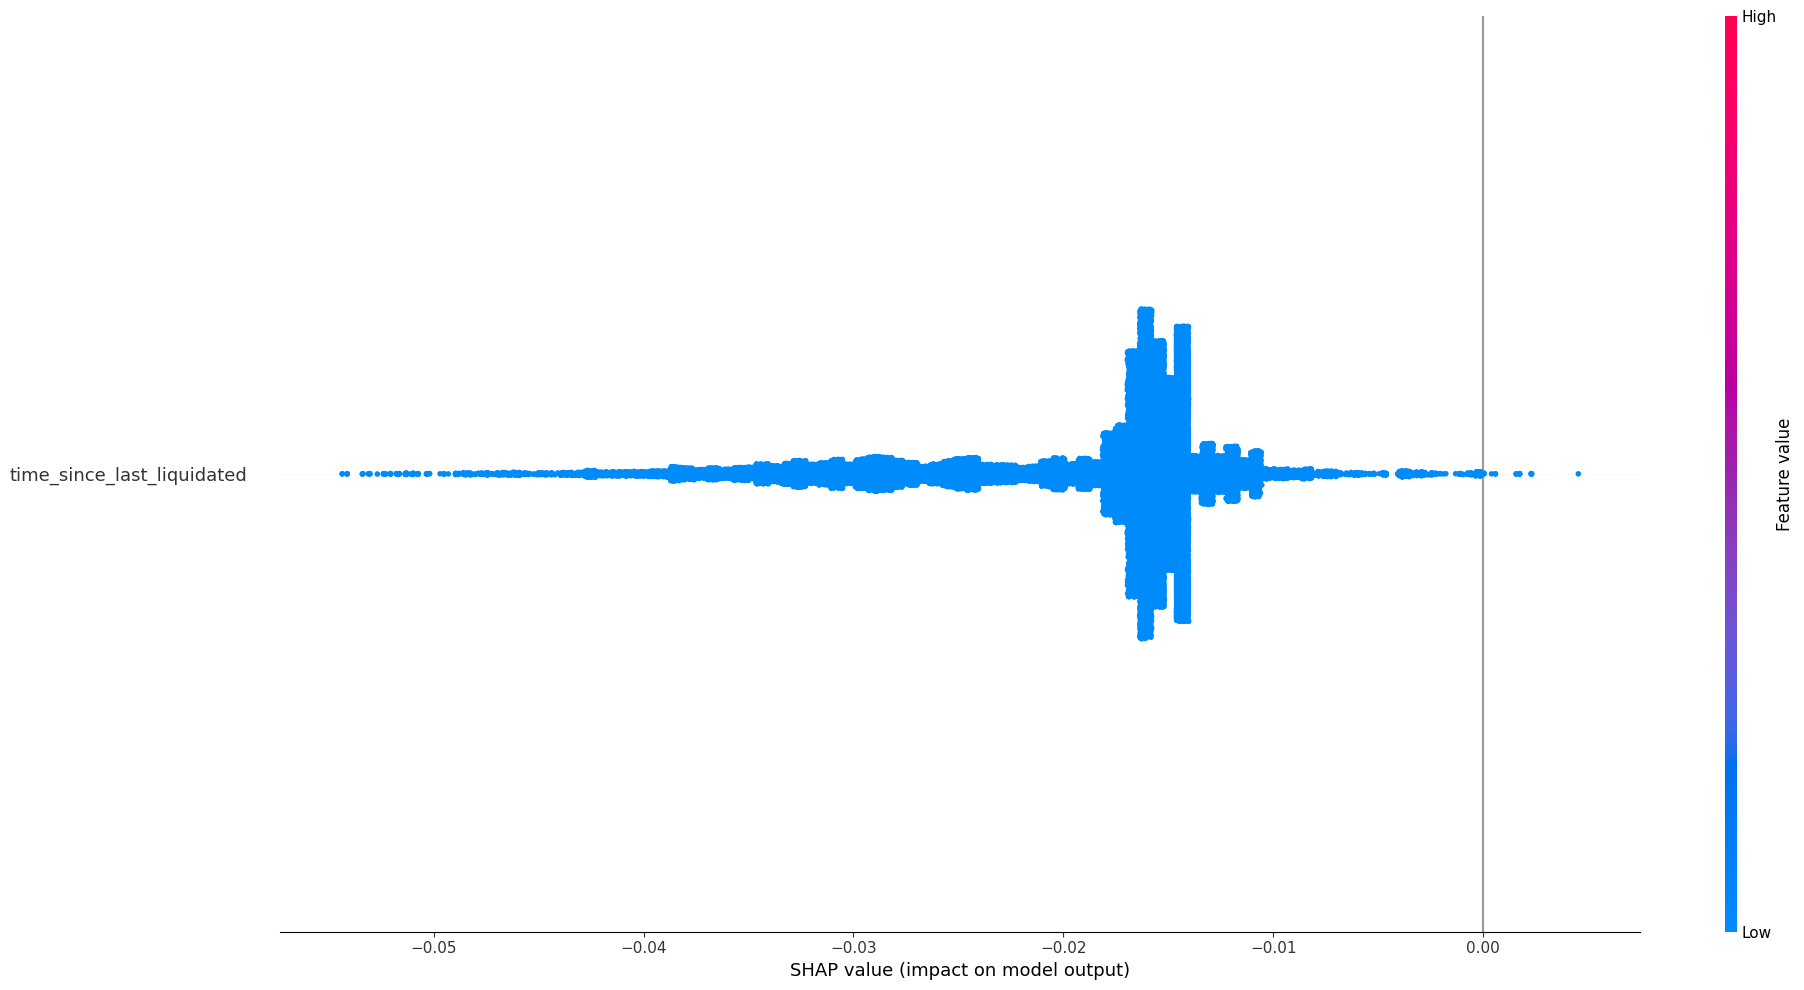

In [99]:
shap.summary_plot(less_shap_values[:, [columns_idx['time_since_last_liquidated']]], X_minus_outliers.iloc[:, [columns_idx['time_since_last_liquidated']]], plot_size=[20,10])


In [100]:
shap.plots.scatter(less_shap_values[:,'time_since_last_liquidated'], color=shap_values)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 34327 and the array at index 1 has size 44296

In [ ]:
explainer = shap.TreeExplainer(xgb_step)
X_minus_outliers = X[X['time_since_last_liquidated'] != X['time_since_last_liquidated'].value_counts().index[0]]
less_shap_values = explainer(X_minus_outliers)

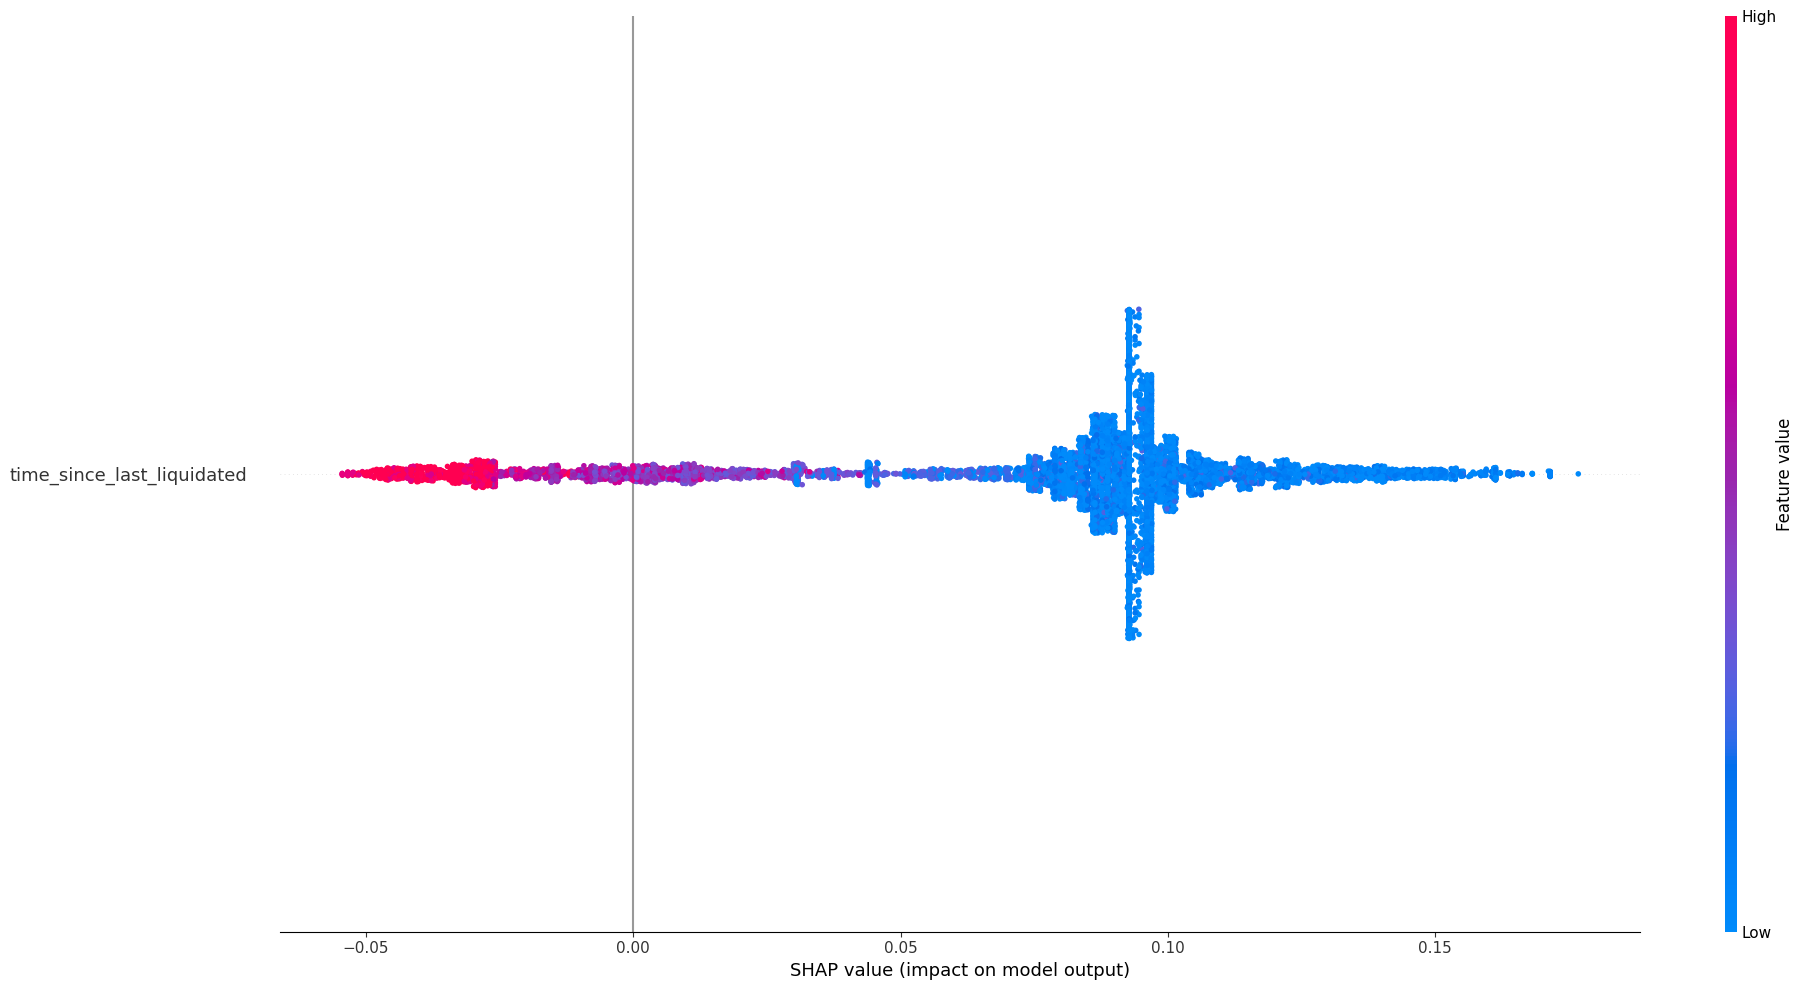

In [ ]:
shap.summary_plot(less_shap_values[:, [columns_idx['time_since_last_liquidated']]], X_minus_outliers.iloc[:, [columns_idx['time_since_last_liquidated']]], plot_size=[20,10])

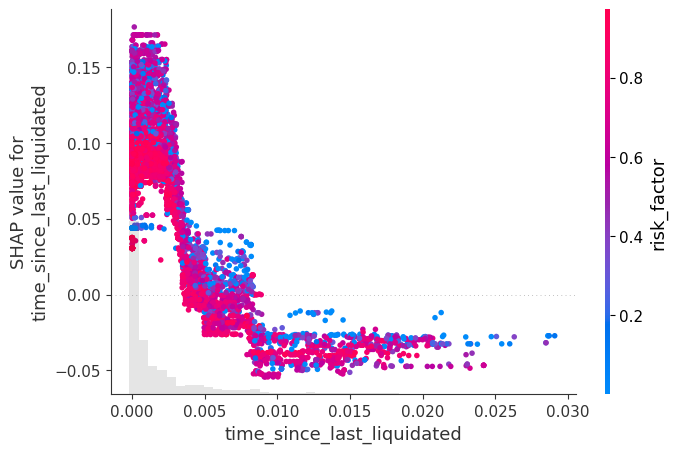

In [ ]:
shap.plots.scatter(less_shap_values[:,'time_since_last_liquidated'], color=shap_values)